In [1]:
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

sys.path.append('../')
from libs import gif
from libs.datasets import MNIST
from libs.utils import montage

%matplotlib inline

plt.rcParams['figure.figsize'] = [16, 9]
plt.style.use('ggplot')

In [2]:
!ls ../1_intro_to_tensorflow/libs/

ls: ../1_intro_to_tensorflow/libs/: No such file or directory


In [3]:
!cat ../info.txt

https://github.com/pkmital/CADL


In [4]:
ds = MNIST()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
ds.X.shape # 70k images, each 28 x 28

(70000, 784)

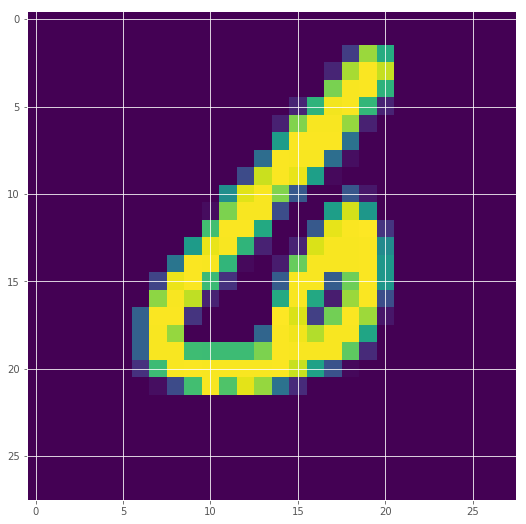

In [6]:
# show 1
plt.imshow(ds.X[40].reshape([28, 28]));

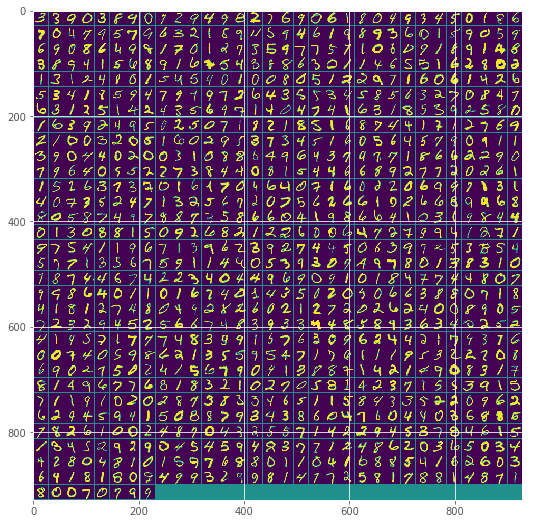

In [7]:
imgs = ds.X[:1000].reshape([-1, 28, 28])
plt.imshow(montage(imgs));

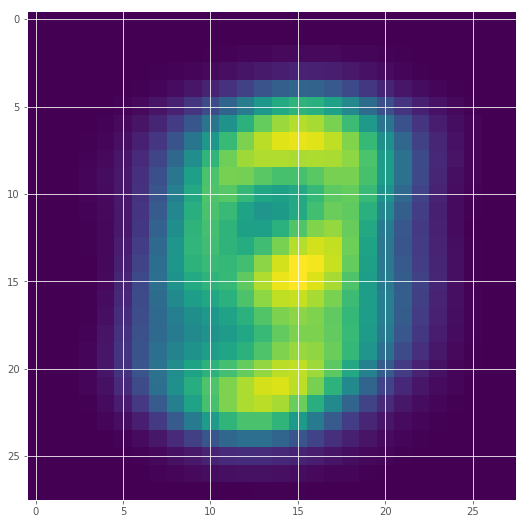

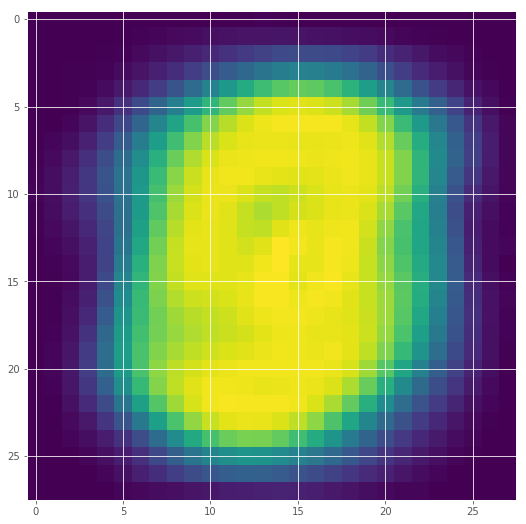

In [8]:
mean_img = np.mean(ds.X, axis=0)
sd_img = np.std(ds.X, axis=0)
plt.imshow(mean_img.reshape([28, 28]));
plt.figure();
plt.imshow(sd_img.reshape([28, 28]));

In [19]:
# network layer sizes:
dimensions = [512, 256, 128, 64]
n_features = ds.X.shape[1]

In [11]:
X = tf.placeholder(tf.float32, [None, n_features])

In [12]:
current_input = X
n_input = n_features
Ws = []

In [15]:
# Encoder
for layer, n_output in enumerate(dimensions):
    with tf.variable_scope('encoder/layer/{}'.format(layer)):
        W = tf.get_variable(
            name='W', 
            shape=[n_input, n_output], 
            initializer=tf.random_normal_initializer(mean=0., stddev=0.02))
        h = tf.matmul(current_input, W)
        # Can also add bias here
        current_input = tf.nn.relu(h)
        Ws.append(W)
        n_input = n_output

In [20]:
# Decoder prep
# Reverse order of weight matrices
Ws = Ws[::-1]
dimensions = dimensions[::-1][1:] + [ds.X.shape[1]]
dimensions

[128, 256, 512, 784]

In [21]:
# Decoder
for layer, n_output in enumerate(dimensions):
    with tf.variable_scope('decoder/layer/{}'.format(layer)):
        W = tf.transpose(Ws[layer])
        h = tf.matmul(current_input, W)
        current_input = tf.nn.relu(h)
        n_input = n_output

In [22]:
Y = current_input

In [24]:
cost = tf.reduce_mean(tf.squared_difference(X, Y), 1)
print(cost.get_shape())
cost = tf.reduce_mean(cost)

(?,)


In [25]:
eta = 0.001
optimizer = tf.train.AdamOptimizer(eta).minimize(cost)

0 0.0430638
1 0.0364553
2 0.0346467
3 0.0324479
4 0.0312681
5 0.0295248
6 0.0307227
7 0.0293348
8 0.0286038
9 0.0282216
10 0.0282817
11 0.0291138
12 0.0275302
13 0.0270993
14 0.0278023
15 0.0277556
16 0.0277355
17 0.0269371
18 0.0273962
19 0.0278529
20 0.0264122
21 0.0259959
22 0.0263071
23 0.0259844
24 0.0270664
25 0.0271208
26 0.0261069
27 0.0271741
28 0.0262605
29 0.0265506
30 0.0259322
31 0.026043
32 0.0251662
33 0.0263588
34 0.0252927
35 0.0254701
36 0.0261792
37 0.0253182
38 0.0266709
39 0.0255484
40 0.0260225
41 0.0251701
42 0.0249665
43 0.0254949
44 0.0256639
45 0.0250803
46 0.0252794
47 0.0250784
48 0.0255527
49 0.0249439
50 0.025173
51 0.0251688
52 0.0251686
53 0.0252331
54 0.0246781
55 0.0249443
56 0.025897
57 0.0243277
58 0.024573
59 0.0246368
60 0.0251952
61 0.0254736
62 0.0245971
63 0.0257588
64 0.0243166
65 0.0256858
66 0.0248502
67 0.0255719
68 0.0254595
69 0.0254217
70 0.023853
71 0.0249024
72 0.0243968
73 0.024914
74 0.0246065
75 0.0247525
76 0.0246788
77 0.0241249
78

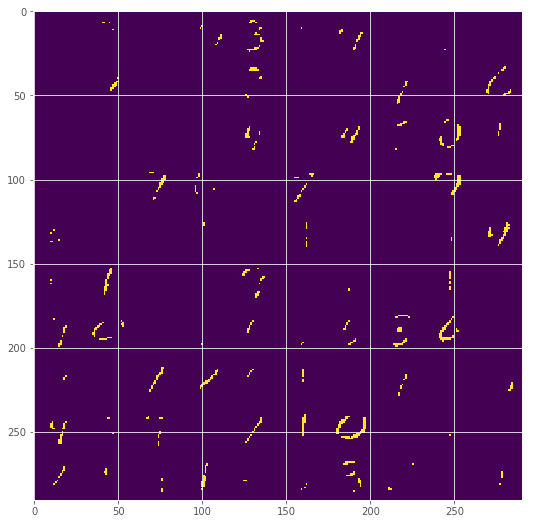

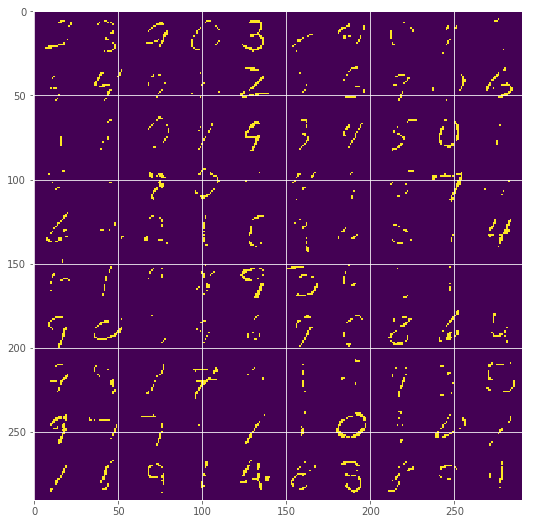

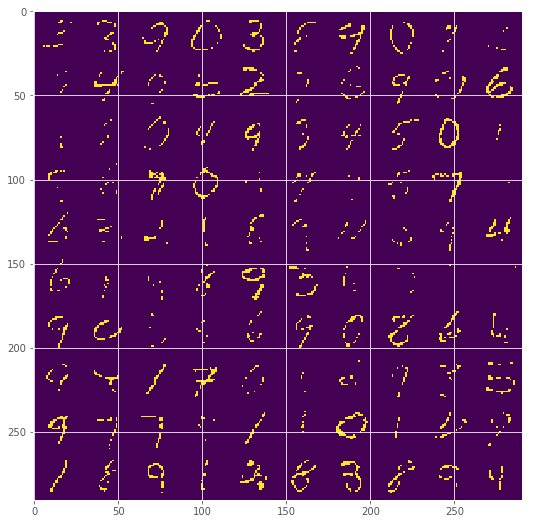

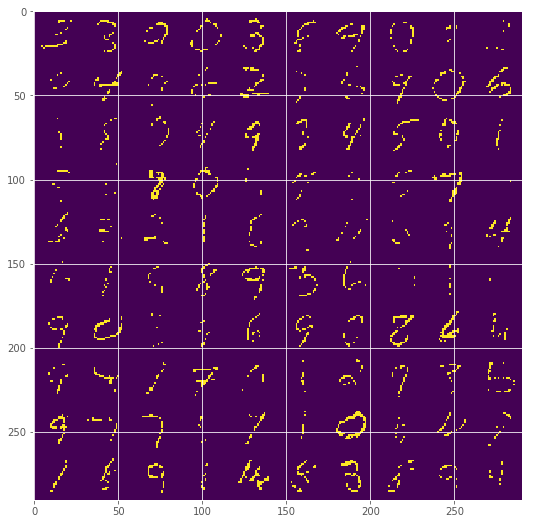

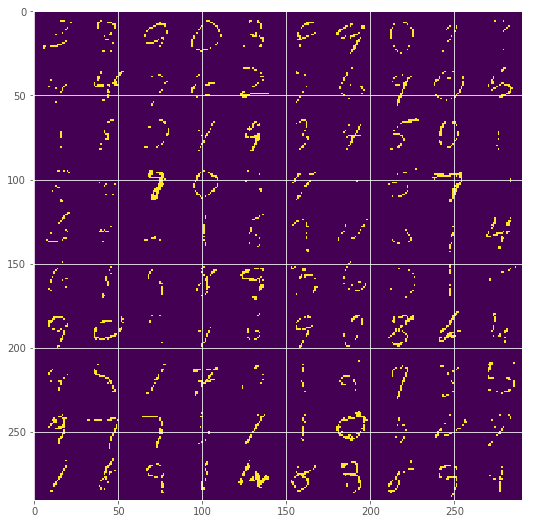

In [29]:
s = tf.Session()
s.run(tf.global_variables_initializer())
batch_size = 100
n_epochs = 100
examples = ds.X[:100]
imgs = []

for epoch in range(n_epochs):
    for batch, _ in ds.train.next_batch():
        s.run(optimizer, feed_dict={ X: batch - mean_img })
    if epoch % 20 == 0:
        recon = s.run(Y, feed_dict={ X: examples - mean_img })
        recon = np.clip((recon + mean_img).reshape([-1, 28, 28]), 0, 255)
        img = montage(recon).astype(np.uint8)
        imgs.append(img)
        plt.figure();
        plt.imshow(img);
    print(epoch, s.run(cost, feed_dict={ X: batch - mean_img }))
    
# gif.build_gif(imgs, saveto='ae.gif', cmap='gray')
    
s.close()